# <a id='toc1_'></a>[Определение возраста покупателей](#toc0_)

## <a id='toc1_1_'></a>[Описание проекта](#toc0_)
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.


Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## <a id='toc1_2_'></a>[Этапы проекта](#toc0_)
- Провести исследовательский анализ набора фотографий.
- Подготовка данных к обучению.
- Обучение нейронной сети и оценка её качества. Целевая метрика MAE должна составить не менее 7.

## <a id='toc1_3_'></a>[Инструменты](#toc0_)
keras  
tensorflow  
matplotlib   
pandas  

**Table of contents**<a id='toc0_'></a>    
- [Определение возраста покупателей](#toc1_)    
  - [Описание проекта](#toc1_1_)    
  - [Этапы проекта](#toc1_2_)    
  - [Инструменты](#toc1_3_)    
- [Исследовательский анализ данных](#toc2_)    
  - [Выводы:](#toc2_1_)    
  - [Анализ обученной модели](#toc2_2_)    
- [Вывод:](#toc3_)    
- [Оценка важности признаков](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Исследовательский анализ данных](#toc0_)

In [1]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D,GlobalAveragePooling2D, Dropout, Input, BatchNormalization, ReLU, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import  ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras import layers
from keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import numpy as np
import pandas as pd
import optuna
from optuna.trial import TrialState
from optuna.visualization.matplotlib._matplotlib_imports import _imports
import cv2 as cv
from cv2 import imread
from cv2 import imshow
from cv2 import waitKey
from cv2 import destroyAllWindows
from cv2 import CascadeClassifier
from cv2 import rectangle
from cv2 import imwrite
seed=43
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

c:\Users\Admin\.conda\envs\tf_gpu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
df=pd.read_csv('E:/Data/_Projects/datasets/appa_real_dace_cropped/labels.csv')
df.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


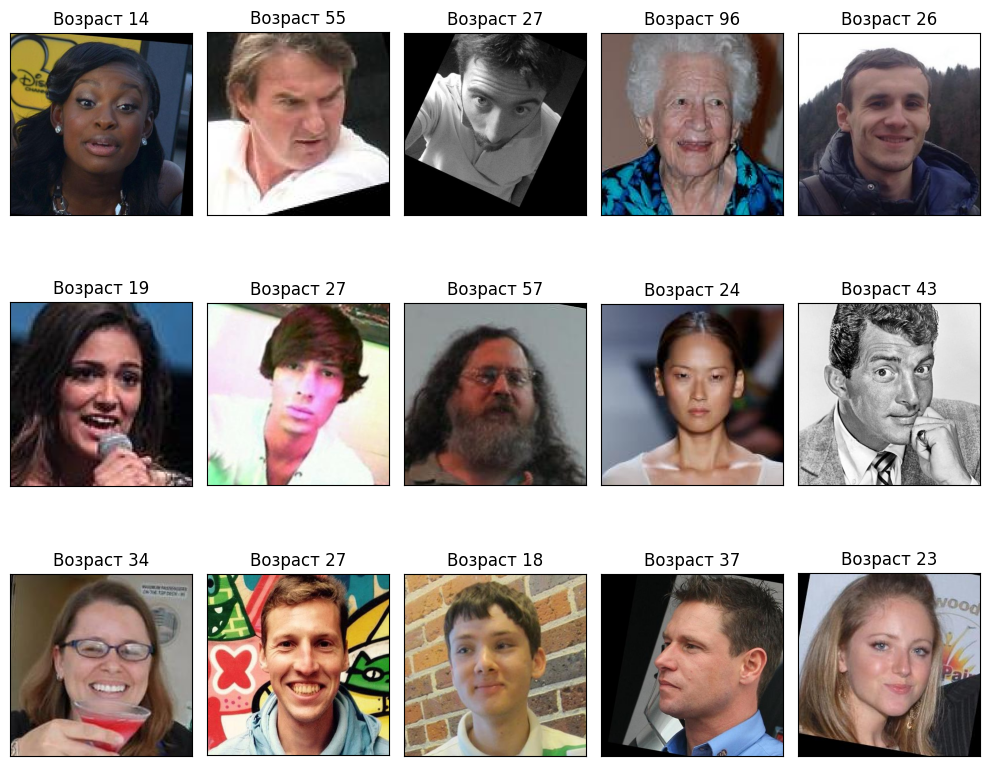

In [7]:
# выводим 15 изображений
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    idx=random.randint(1,len(df))
    img=imread('E:/Data/_Projects/datasets/appa_real_dace_cropped/final_files/final_files/'+df.iloc[idx]['file_name'])
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title("Возраст "+str(df.iloc[idx]['real_age']))

In [8]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=20, 
        width_shift_range=0.2, 
        height_shift_range=0.2    
        )
    path2=path+'final_files/final_files/'
    train_datagen_flow = train_datagen.flow_from_dataframe(df,
    path2,
    x_col='file_name',
    y_col='real_age',
    target_size=(330, 330),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345)
 
    return train_datagen_flow

In [9]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
        )
    path2=path+"final_files/final_files/"
    test_datagen_flow = train_datagen.flow_from_dataframe(df,
    path2,
    x_col='file_name',
    y_col='real_age',
    target_size=(330, 330),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345)
 
    return test_datagen_flow

In [10]:
train_datagen_flow= load_train('E:/Data/_Projects/datasets/appa_real_dace_cropped/')
test_datagen_flow= load_test('E:/Data/_Projects/datasets/appa_real_dace_cropped/')

Found 5694 validated image filenames.
Found 1897 validated image filenames.


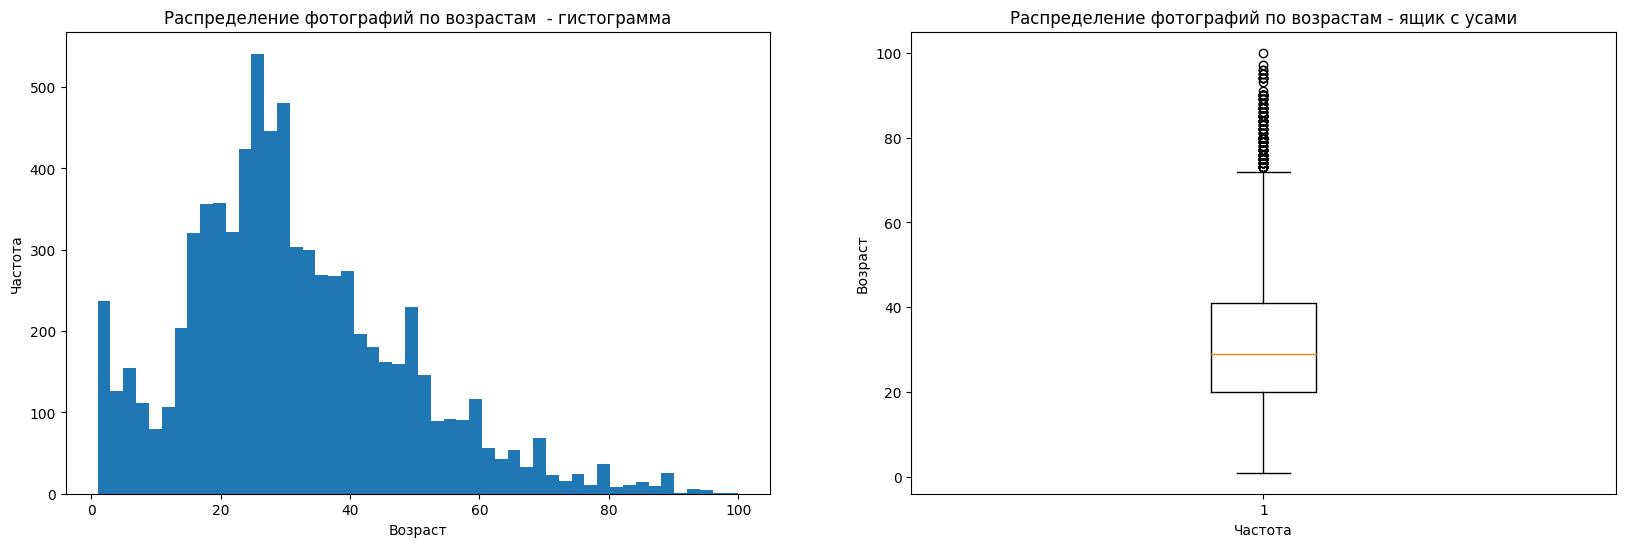

In [11]:
#Построим график распределения по возрасту в тестовой выборке
f, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].hist(df['real_age'], bins=50)
axs[0].set(title='Распределение фотографий по возрастам  - гистограмма',ylabel='Частота',xlabel='Возраст')
axs[1].boxplot(df['real_age'])
axs[1].set(title='Распределение фотографий по возрастам - ящик с усами',xlabel='Частота',ylabel='Возраст')
plt.show()

In [12]:
print(len(train_datagen_flow)*16)
print(len(test_datagen_flow)*16)

5696
1904


## <a id='toc2_1_'></a>[Выводы:](#toc0_)
1. Мы получили тренировочный набор данных из 5696 фотографий и тестовый из 1904.
2. В тренировочном наборе данных распределение возрастов похоже на нормальное, чуть смещённое влево, что соответствует реальной картине - ибо не так много людей доживает до 100 лет.
3. Явных аномалий не замечено, нет людей с трицательным возрастом или аномально большим.
4. Пропусков возраста тоже не наблоюдается.
5. Фотографии людей разного качества, под разными ракурсами, с разным освещением и попадаются даже черно-белые. Все условия созданы, чтобы хорошо обучить модель.

In [13]:
def train_model(model, train_data, test_data, epochs=5,
                batch_size=None, steps_per_epoch=None,
                validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
 
    if validation_steps is None:
        validation_steps = len(test_data) 
    checkpointer = ModelCheckpoint(filepath='E:/Data/_Projects/datasets/age_model.hdf5'
        , monitor = "val_mae", verbose=1, save_best_only=True, mode = 'auto')
    reduce_lr = ReduceLROnPlateau(min_delta=0.05, patience=6, verbose=2)
    early_stop = EarlyStopping(monitor='mae', min_delta=0.15, mode="auto", patience=5,verbose=2)
    history=model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, callbacks=[reduce_lr,early_stop,checkpointer])
    return model

In [14]:
def create_model3(input_shape,dropout=0.2,lr=0.001,dense=64):
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(Dropout(dropout))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(dense, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    return model


In [15]:
def optimize_structure(trial):
    n = trial.suggest_int("n_units", 500, 1024)
    d=trial.suggest_float("dropout", 0.5, 0.75)
    lr=trial.suggest_float("learning_rate", 0.00001, 0.0001)
    net = create_model3(input_shape=(330, 330, 3),dropout=d,lr=lr,dense=n)
    num_epochs = 4
    net=train_model(net, train_datagen_flow, test_datagen_flow, epochs=num_epochs,batch_size=16)
    results = net.evaluate(test_datagen_flow, batch_size=16)
    if trial.should_prune():
            raise optuna.TrialPruned()
    return results[0]

In [16]:
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize",pruner=optuna.pruners.HyperbandPruner())
    study.optimize(optimize_structure, n_trials=5, timeout=6000)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials)) 
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-02-15 09:03:51,785] A new study created in memory with name: no-name-86e8abd1-38cb-4c7f-bcf1-ba96748625ac


Epoch 1/4

Epoch 1: val_mae improved from inf to 19.07463, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 230s - loss: 10.8393 - mae: 10.8393 - val_loss: 19.0746 - val_mae: 19.0746 - lr: 5.0580e-05 - 230s/epoch - 645ms/step
Epoch 2/4

Epoch 2: val_mae improved from 19.07463 to 9.45780, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 124s - loss: 8.0667 - mae: 8.0667 - val_loss: 9.4578 - val_mae: 9.4578 - lr: 5.0580e-05 - 124s/epoch - 348ms/step
Epoch 3/4

Epoch 3: val_mae improved from 9.45780 to 7.15885, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 135s - loss: 7.3714 - mae: 7.3714 - val_loss: 7.1588 - val_mae: 7.1588 - lr: 5.0580e-05 - 135s/epoch - 380ms/step
Epoch 4/4

Epoch 4: val_mae improved from 7.15885 to 6.43686, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 140s - loss: 6.7975 - mae: 6.7975 - val_loss: 6.4369 - val_mae: 6.4369 - lr: 5.0580e-05 - 140s/epoch - 394ms/step
119/119 [=============

[I 2024-02-15 09:14:41,910] Trial 0 finished with value: 6.436854839324951 and parameters: {'n_units': 1004, 'dropout': 0.534240569245025, 'learning_rate': 5.057979826750625e-05}. Best is trial 0 with value: 6.436854839324951.


Epoch 1/4

Epoch 1: val_mae improved from inf to 15.01137, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 158s - loss: 11.6910 - mae: 11.6910 - val_loss: 15.0114 - val_mae: 15.0114 - lr: 2.2688e-05 - 158s/epoch - 444ms/step
Epoch 2/4

Epoch 2: val_mae improved from 15.01137 to 10.73971, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 116s - loss: 8.1815 - mae: 8.1815 - val_loss: 10.7397 - val_mae: 10.7397 - lr: 2.2688e-05 - 116s/epoch - 326ms/step
Epoch 3/4

Epoch 3: val_mae improved from 10.73971 to 7.19057, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 111s - loss: 7.4893 - mae: 7.4893 - val_loss: 7.1906 - val_mae: 7.1906 - lr: 2.2688e-05 - 111s/epoch - 313ms/step
Epoch 4/4

Epoch 4: val_mae improved from 7.19057 to 6.84680, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 114s - loss: 6.8586 - mae: 6.8586 - val_loss: 6.8468 - val_mae: 6.8468 - lr: 2.2688e-05 - 114s/epoch - 319ms/step
119/119 [=========

[I 2024-02-15 09:23:13,061] Trial 1 finished with value: 6.846794605255127 and parameters: {'n_units': 1001, 'dropout': 0.5577031659101082, 'learning_rate': 2.2687752128538034e-05}. Best is trial 0 with value: 6.436854839324951.


Epoch 1/4

Epoch 1: val_mae improved from inf to 15.72195, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 117s - loss: 11.1404 - mae: 11.1404 - val_loss: 15.7220 - val_mae: 15.7220 - lr: 3.1157e-05 - 117s/epoch - 329ms/step
Epoch 2/4

Epoch 2: val_mae improved from 15.72195 to 9.60094, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 128s - loss: 8.0611 - mae: 8.0611 - val_loss: 9.6009 - val_mae: 9.6009 - lr: 3.1157e-05 - 128s/epoch - 359ms/step
Epoch 3/4

Epoch 3: val_mae improved from 9.60094 to 6.41122, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 135s - loss: 7.2632 - mae: 7.2632 - val_loss: 6.4112 - val_mae: 6.4112 - lr: 3.1157e-05 - 135s/epoch - 380ms/step
Epoch 4/4

Epoch 4: val_mae did not improve from 6.41122
356/356 - 129s - loss: 6.7243 - mae: 6.7243 - val_loss: 7.6603 - val_mae: 7.6603 - lr: 3.1157e-05 - 129s/epoch - 363ms/step
119/119 [==============================] - 17s 142ms/step - loss: 7.6603 - mae: 7.660

[I 2024-02-15 09:32:01,232] Trial 2 finished with value: 7.6602678298950195 and parameters: {'n_units': 918, 'dropout': 0.6836761848523484, 'learning_rate': 3.115734405877547e-05}. Best is trial 0 with value: 6.436854839324951.


Epoch 1/4

Epoch 1: val_mae improved from inf to 13.60739, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 141s - loss: 12.8155 - mae: 12.8155 - val_loss: 13.6074 - val_mae: 13.6074 - lr: 1.9182e-05 - 141s/epoch - 395ms/step
Epoch 2/4

Epoch 2: val_mae improved from 13.60739 to 12.34855, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 132s - loss: 8.2558 - mae: 8.2558 - val_loss: 12.3486 - val_mae: 12.3486 - lr: 1.9182e-05 - 132s/epoch - 371ms/step
Epoch 3/4

Epoch 3: val_mae improved from 12.34855 to 7.28356, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 133s - loss: 7.3858 - mae: 7.3858 - val_loss: 7.2836 - val_mae: 7.2836 - lr: 1.9182e-05 - 133s/epoch - 373ms/step
Epoch 4/4

Epoch 4: val_mae improved from 7.28356 to 6.37088, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 131s - loss: 6.8644 - mae: 6.8644 - val_loss: 6.3709 - val_mae: 6.3709 - lr: 1.9182e-05 - 131s/epoch - 367ms/step
119/119 [=========

[I 2024-02-15 09:41:16,231] Trial 3 finished with value: 6.37088680267334 and parameters: {'n_units': 680, 'dropout': 0.5122204059231383, 'learning_rate': 1.9181612959108517e-05}. Best is trial 3 with value: 6.37088680267334.


Epoch 1/4

Epoch 1: val_mae improved from inf to 14.79156, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 135s - loss: 10.5942 - mae: 10.5942 - val_loss: 14.7916 - val_mae: 14.7916 - lr: 7.4175e-05 - 135s/epoch - 379ms/step
Epoch 2/4

Epoch 2: val_mae improved from 14.79156 to 10.45587, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 130s - loss: 8.2009 - mae: 8.2009 - val_loss: 10.4559 - val_mae: 10.4559 - lr: 7.4175e-05 - 130s/epoch - 365ms/step
Epoch 3/4

Epoch 3: val_mae improved from 10.45587 to 7.03774, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 129s - loss: 7.4864 - mae: 7.4864 - val_loss: 7.0377 - val_mae: 7.0377 - lr: 7.4175e-05 - 129s/epoch - 363ms/step
Epoch 4/4

Epoch 4: val_mae did not improve from 7.03774
356/356 - 124s - loss: 6.9695 - mae: 6.9695 - val_loss: 7.1037 - val_mae: 7.1037 - lr: 7.4175e-05 - 124s/epoch - 349ms/step
119/119 [==============================] - 17s 140ms/step - loss: 7.1037 - mae: 7

[I 2024-02-15 09:50:12,550] Trial 4 finished with value: 7.103739261627197 and parameters: {'n_units': 501, 'dropout': 0.5598604852180382, 'learning_rate': 7.417544213715328e-05}. Best is trial 3 with value: 6.37088680267334.


Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  6.37088680267334
  Params: 
    n_units: 680
    dropout: 0.5122204059231383
    learning_rate: 1.9181612959108517e-05


C:\Users\Admin\AppData\Local\Temp\ipykernel_14108\1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

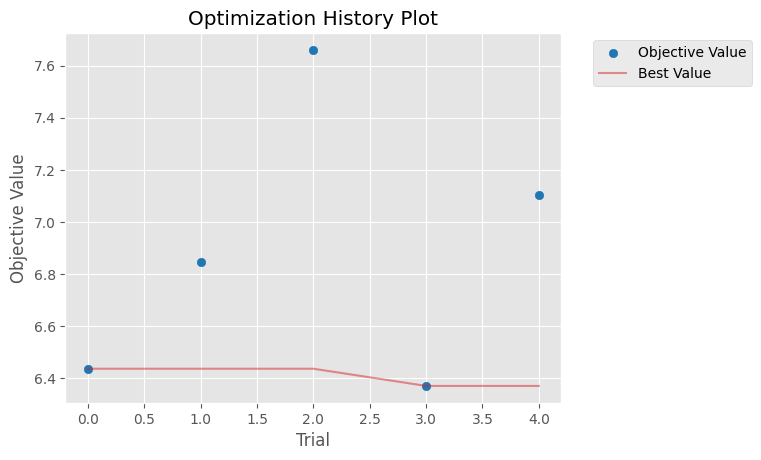

In [17]:
optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14108\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

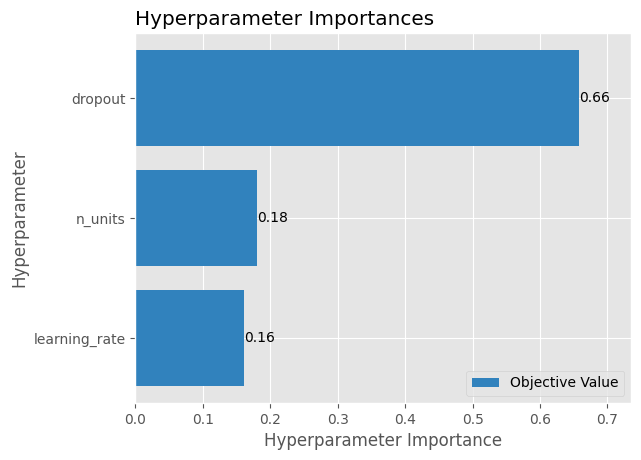

In [18]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [19]:
net = create_model3(input_shape=(330, 330, 3),dropout=trial.params['dropout'],lr=trial.params['learning_rate'],dense=trial.params['n_units'])
num_epochs = 20
net=train_model(net, train_datagen_flow, test_datagen_flow, epochs=num_epochs,batch_size=16)

Epoch 1/20

Epoch 1: val_mae improved from inf to 18.20931, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 137s - loss: 12.3249 - mae: 12.3249 - val_loss: 18.2093 - val_mae: 18.2093 - lr: 1.9182e-05 - 137s/epoch - 385ms/step
Epoch 2/20

Epoch 2: val_mae improved from 18.20931 to 9.40312, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 132s - loss: 8.1967 - mae: 8.1967 - val_loss: 9.4031 - val_mae: 9.4031 - lr: 1.9182e-05 - 132s/epoch - 371ms/step
Epoch 3/20

Epoch 3: val_mae improved from 9.40312 to 7.43820, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 130s - loss: 7.5014 - mae: 7.5014 - val_loss: 7.4382 - val_mae: 7.4382 - lr: 1.9182e-05 - 130s/epoch - 365ms/step
Epoch 4/20

Epoch 4: val_mae improved from 7.43820 to 7.42354, saving model to E:/Data/_Projects/datasets\age_model.hdf5
356/356 - 130s - loss: 6.9696 - mae: 6.9696 - val_loss: 7.4235 - val_mae: 7.4235 - lr: 1.9182e-05 - 130s/epoch - 365ms/step
Epoch 5/20

Epoch 

# <a id='toc2_2_'></a>[Анализ обученной модели](#toc0_)

Мы использовали готовую архитектуру ResNet50, с небольшой кастомизацией.  
В результате получилась нейросеть дающая точность на тестовой выборке 5,8. Это лучше чем целевое значение 8.  
При этом мы максимально экономили машинные мощности и обучали модель всего на 20 эпохах и провели только 5 раундов оптимизации на optuna. При наличии ресурсов, реузльтат можно было бы ещё улучшить.

In [20]:
net.load_weights('E:/Data/_Projects/datasets/age_model.hdf5')
results = net.evaluate(test_datagen_flow, batch_size=16)

119/119 [==============================] - 9s 76ms/step - loss: 5.8241 - mae: 5.8241


In [162]:
x,y=test_datagen_flow.next()
predictions=net.predict(x)
predictions=predictions.flatten().tolist()
y=y.tolist()


1/1 [==============================] - 0s 28ms/step


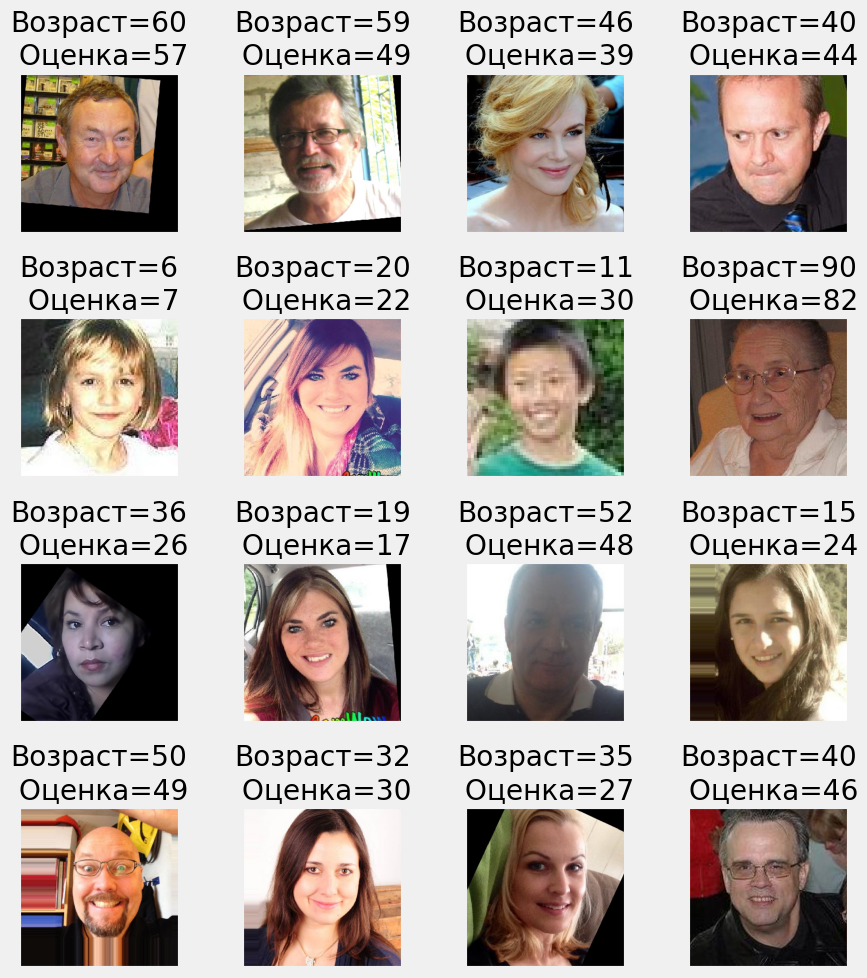

In [161]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title("Возраст="+str(y[i])+"\n Оценка="+str(round(predictions[i])))


**Вывод**  

- Модель ошибается где-то на 5-6 лет. 
Это модет оказаться критичным, например, в вопросах продажи алкоголя несовершеннолетним.  
- Тем не менее, подобной точности вполне достаточно, чтобы классифицировать по возрастным группам наших покупателей, и анализировать их потребительские предпочтения более фокусировано. Основанный на собранных моделью данных, анализ наверняка будет точен, и его результаты поспособствуют оптимизации продуктовой матрицы заказчика.

In [22]:
young=df[df['real_age']<18]
train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )
path2="E:/Data/_Projects/datasets/appa_real_dace_cropped/final_files/final_files/"
young_datagen_flow = train_datagen.flow_from_dataframe(young,
    path2,
    x_col='file_name',
    y_col='real_age',
    target_size=(330, 330),
    class_mode='raw',
    seed=12345)


Found 1503 validated image filenames.


In [23]:
y_predz=net.predict(young_datagen_flow)

47/47 [==============================] - 11s 198ms/step


In [24]:
pd.options.mode.chained_assignment = None  # default='warn'
young['predict']=y_predz
young['error']=young['predict'].apply(lambda x: 1 if x>18 else 0)
error_count=young.value_counts('error')
print(error_count)
print("Доля ошибок при определении клиентов моложе 18 лет", round(error_count[1]/len(young)*100,2),"%")

error
0    1295
1     208
Name: count, dtype: int64
Доля ошибок при определении клиентов моложе 18 лет 13.84 %


  
**Вывод**
- Модель существенно снижает трудозатраты продавцов, верно вычисляя несовершеннолетних в 86% случаев. Т.е. почти в 7 раз меньше вероятность продать табак и алкоголь несовершеннолетним, а значит меньше штрафов  и недовольных родителей. Сомневаюсь, что живые продавцы, в большинстве своём, точнее определяют возраст на глаз.